# Optimization of Dimensionality Witness Nonlocality

### Goal: Optimize nonlocality against simple qubit dimensionality witnesses

### Background:

Dimensionality witnesses are Bell inequalities for bipartite prepare and measure scenarios (see [Device-Independent Tests of Classical and Quantum Dimensions](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.105.230501)).
In this setting, Alice and Bob receive independent inputs $x$ and $y$ respectively.
Alice encodes input $x$ into a quantum states $\rho_x$ which is then sent to Bob over a quantum channel.
Bob performs a measurent $\Pi_b^y$ conditioned on input $y$ to produce an output $b\in\{0,1\}$.
A simple Bell inequality with known quantum violations is expressed as:

$$I_3 \equiv |\langle B_{11}\rangle + \langle B_{12} \rangle + \langle B_{21} \rangle - \langle B_{22} \rangle - \langle B_{31} \rangle  | \leq 3$$

where $\langle B_{xy} \rangle = P(0|xy) - P(1|xy)$. The bound on the quantum score is $I_3 \leq 1 + 2\sqrt{2} \approx 3.8284$. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


### Setup Quantum Circuits

In [2]:
# The I_3 dimensionality witness only requires one qubit to simulate
dev = qml.device("default.qubit", wires=1)

# optimizer
opt = qml.GradientDescentOptimizer()

@qml.qnode(dev)
def real_I3_circuit(θ_state, θ_measurement):  
    """
    Ansatz circuit where states ρ_x and measurements Π_b^y are free to rotate about the y-axis.
    In this model, all quantum states real.

    Args:
        θ_state (float) : rotation angle on ρ_x
        θ_measurement (float) : rotation angle on Π_b^y
    """    
    qml.RY(θ_state, wires=0)
    qml.RY(θ_measurement, wires=0)
    
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev)
def arbitrary_I3_circuit(state_params, measurement_params):
    """
    Ansatz circuit where states ρ_x are prepared with a single qubit `ArbitraryUnitary` gate and
    measurements Π_b^y are prepared with a single qubit `ArbitraryUnitary` gate.

    Args:
        state_params (list[float]) : 3 angle parameters for the arbitrary qubit state.
        measurement_params (list[float]) : 3 angle parameters for the arbitrary measurement.
    """
    qml.templates.subroutines.ArbitraryUnitary(state_params, [0])
    qml.templates.subroutines.ArbitraryUnitary(measurement_params, [0])
    return qml.expval(qml.PauliZ(0))

### Setup Cost Functions for the Optimization

In [3]:
def real_I3_cost(real_settings):
    """
    Evaluates the I3 inequality by running the `real_I3_circuit` with parameters specified
    by `real_settings`.
    
    Args:
        real_settings (list[float]) : 5-element list
    """
    B_11 = real_I3_circuit(real_settings[0], real_settings[3])
    B_12 = real_I3_circuit(real_settings[0], real_settings[4])
    B_21 = real_I3_circuit(real_settings[1], real_settings[3])
    B_22 = real_I3_circuit(real_settings[1], real_settings[4])
    B_31 = real_I3_circuit(real_settings[2], real_settings[3])
    return -(B_11 + B_12 + B_21 - B_22 - B_31)

def arbitrary_I3_cost(arb_settings):
    """
    Evaluates the I3 inequality by running the `arbitrary_I3_circuit` with parameters specified
    by `arb_settings`.
    
    Args:
        arb_settings (list[float]) : 15-element list
    """
    B_11 = arbitrary_I3_circuit(arb_settings[0:3], arb_settings[9:12])
    B_12 = arbitrary_I3_circuit(arb_settings[0:3], arb_settings[12:15])
    B_21 = arbitrary_I3_circuit(arb_settings[3:6], arb_settings[9:12])
    B_22 = arbitrary_I3_circuit(arb_settings[3:6], arb_settings[12:15])
    B_31 = arbitrary_I3_circuit(arb_settings[6:9], arb_settings[9:12])
    return -(B_11 + B_12 + B_21 - B_22 - B_31)

### Methods to Randomize Initial Parameters

In [4]:
def real_I3_rand_settings():
    """
    Returns a 5-element list with the randomized angles of the `real_I3_cost` method.
    """
    return 2*np.pi*np.random.random(5) - np.pi

def arbitrary_I3_rand_settings():
    """
    Returns a 15-element list with the randomized angles of the `arbitrary_I3_cost` method.
    """
    return 2*np.pi*np.random.random(15) - np.pi

### Optimizing $I_3$ Inequality over Real Parameter Space

In [5]:
# initial settings
real_settings = real_I3_rand_settings()
real_scores = []

# performing gradient descent
for i in range(500):
    real_settings = opt.step(real_I3_cost, real_settings)
    score = -(real_I3_cost(real_settings))
    real_scores.append(score)
    
    
    if i%50 == 0:
        print("iteration : ",i, ", cost : ", score)
        print("settings :\n", real_settings, "\n")


# printing final results    
print("final cost : ", real_I3_cost(real_settings),",")
print("final settings : ", real_settings)

iteration :  0 , cost :  0.43244799805884626
settings :
 [-0.89785908  2.37612914 -3.07431242 -0.10736694 -0.97172404] 

iteration :  50 , cost :  2.8869576084251283
settings :
 [-0.22043158  2.46060351 -3.05349018 -0.16479733 -0.13156955] 

iteration :  100 , cost :  3.3016044882075315
settings :
 [-0.0263346   2.3569793  -2.98812979 -0.33750878  0.19697505] 

iteration :  150 , cost :  3.5101023148679547
settings :
 [ 0.035922    2.16161085 -2.8795775  -0.5067848   0.34169152] 

iteration :  200 , cost :  3.6606511436049116
settings :
 [ 0.06838787  1.97945518 -2.7559355  -0.63185548  0.4407144 ] 

iteration :  250 , cost :  3.7456115288667213
settings :
 [ 0.08448387  1.84880259 -2.64192108 -0.70905401  0.51737075] 

iteration :  300 , cost :  3.7880536778163356
settings :
 [ 0.08889018  1.76520575 -2.54936912 -0.75424427  0.57592245] 

iteration :  350 , cost :  3.8086570088597753
settings :
 [ 0.08660483  1.71365536 -2.4793678  -0.7816977   0.61954146] 

iteration :  400 , cost : 

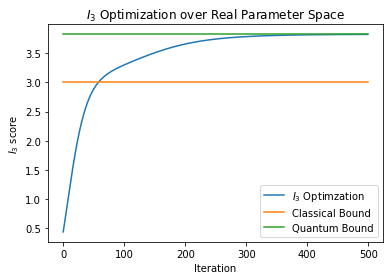

In [6]:
# Plot the individual observables
plt.plot(range(500), real_scores , label = r"$I_3$ Optimzation")
plt.plot(range(500), [3]*500, label = r"Classical Bound")
plt.plot(range(500), [1+2*np.sqrt(2)]*500, label = r"Quantum Bound")
plt.title(r"$I_3$ Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$I_3$ score")
plt.legend()
plt.show()

### Optimize $I_3$ Inequality over Complex Parameter Space

In [7]:
# initial settings
arb_settings = arbitrary_I3_rand_settings()
arb_scores = []

# performing gradient descent
for i in range(500):
    arb_settings = opt.step(arbitrary_I3_cost, arb_settings)
    
    score = -(arbitrary_I3_cost(arb_settings))
    arb_scores.append(score)
    
    if i%50 == 0:
        print("iteration : ",i, ", score : ", score)
        print("settings :\n", arb_settings, "\n")

# printing final results    
print("final score : ", arbitrary_I3_cost(arb_settings),",")
print("final settings : ", arb_settings)

iteration :  0 , score :  0.11601534914148431
settings :
 [ 2.8980497  -0.73556805  0.75723606 -0.13858362  2.30839725 -1.23888577
 -1.27587604 -3.03357787  1.92597107  2.33240853 -0.10778687  2.94182792
 -1.46665883 -0.23978071 -2.95020405] 

iteration :  50 , score :  2.9594147567632847
settings :
 [ 2.65423106 -0.68796418  0.59250561 -0.46197015  2.9930754  -0.92192981
 -1.63003852 -3.00225898  2.06803537  2.60453871 -0.68609626  2.94182792
 -1.39596754 -0.40010587 -2.95020405] 

iteration :  100 , score :  3.601901758681818
settings :
 [ 2.44701317 -0.76892562  0.49794998 -0.67273805  3.28568793 -0.73800781
 -1.8692058  -3.00612648  2.06230841  2.68515923 -0.81230657  2.94182792
 -1.35353936 -0.4408053  -2.95020405] 

iteration :  150 , score :  3.7554804435759657
settings :
 [ 2.34241891 -0.84938424  0.47428645 -0.78069615  3.40802241 -0.65401647
 -2.01309696 -3.00558141  2.04176678  2.71790754 -0.83685474  2.94182792
 -1.35100255 -0.44347726 -2.95020405] 

iteration :  200 , scor

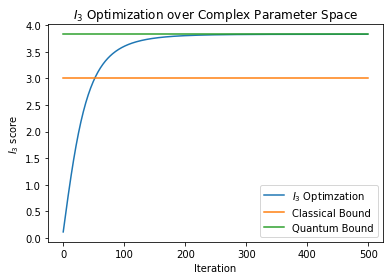

In [8]:
# Plot the individual observables
plt.plot(range(500), arb_scores , label = r"$I_3$ Optimzation")
plt.plot(range(500), [3]*500, label = r"Classical Bound")
plt.plot(range(500), [1+2*np.sqrt(2)]*500, label = r"Quantum Bound")
plt.title(r"$I_3$ Optimization over Complex Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$I_3$ score")
plt.legend()
plt.show()